In [ ]:
!**This project focuses on detecting and recognizing car number plates using PyTorch, YOLOv8n, and OCR. Begin by setting up the environment with the necessary libraries, such as PyTorch, YOLOv8, and an OCR tool like Tesseract. Load a dataset of car images with annotated number plates for training. The YOLOv8n model is fine-tuned to detect number plates, and after training, it’s used to identify plates in new images.**

!**Once a number plate is detected, OCR is applied to extract and process the text. The results, including detected bounding boxes and recognized text, are visualized, and the model’s performance is evaluated. The notebook provides all the necessary steps to replicate this process and explore the effectiveness of the model for number plate recognition.**

# Importing PyTorch and check cuda

In [3]:
#Begin
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [4]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 24.5 MB/s eta 0:00:00


In [5]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
dataset_path = '/content/drive/MyDrive/archive'

# Extracting digits from file name

In [8]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)

    if match:
        return int(match.group(0))
    else:
        return 0

In [9]:
print(the_number_in_the_string("file123.txt"))
print(the_number_in_the_string("no_numbers"))

123
0


# Formatting the XML File and creating DF

In [10]:
#to store labels and image info
labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

In [11]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [12]:
import os
from glob import glob

#get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/annotations/*.xml')
xml_files

['/content/drive/MyDrive/archive/annotations/Cars1.xml',
 '/content/drive/MyDrive/archive/annotations/Cars0.xml',
 '/content/drive/MyDrive/archive/annotations/Cars104.xml',
 '/content/drive/MyDrive/archive/annotations/Cars105.xml',
 '/content/drive/MyDrive/archive/annotations/Cars106.xml',
 '/content/drive/MyDrive/archive/annotations/Cars101.xml',
 '/content/drive/MyDrive/archive/annotations/Cars102.xml',
 '/content/drive/MyDrive/archive/annotations/Cars10.xml',
 '/content/drive/MyDrive/archive/annotations/Cars100.xml',
 '/content/drive/MyDrive/archive/annotations/Cars107.xml',
 '/content/drive/MyDrive/archive/annotations/Cars103.xml',
 '/content/drive/MyDrive/archive/annotations/Cars112.xml',
 '/content/drive/MyDrive/archive/annotations/Cars279.xml',
 '/content/drive/MyDrive/archive/annotations/Cars63.xml',
 '/content/drive/MyDrive/archive/annotations/Cars12.xml',
 '/content/drive/MyDrive/archive/annotations/Cars197.xml',
 '/content/drive/MyDrive/archive/annotations/Cars262.xml',
 '/c

In [13]:
import xml.etree.ElementTree as xet

In [14]:
#CLAHE

import cv2

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):

    info = xet.parse(filename)
    root = info.getroot()

    # Finding BB info
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # join full path
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Read image
    image = cv2.imread(img_path)

    # Convert image to grayscale for CLAHE
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(gray_image)

    # Convert CLAHE image back to BGR (if you need to maintain the color image for later steps)
    clahe_image_bgr = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)

    # Get image dimensions after CLAHE (assuming the dimensions remain the same)
    height, width, _ = clahe_image_bgr.shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

    # add to dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Store the data in a pandas DataFrame
    alldata = pd.DataFrame(labels_dict)

In [15]:
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/drive/MyDrive/archive/images/Cars0.png,226,419,125,173,500,268
1,/content/drive/MyDrive/archive/images/Cars1.png,134,262,128,160,400,248
2,/content/drive/MyDrive/archive/images/Cars2.png,229,270,176,193,400,400
3,/content/drive/MyDrive/archive/images/Cars3.png,142,261,128,157,400,225
4,/content/drive/MyDrive/archive/images/Cars4.png,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/content/drive/MyDrive/archive/images/Cars428.png,142,258,128,157,400,225
429,/content/drive/MyDrive/archive/images/Cars429.png,86,208,166,195,301,400
430,/content/drive/MyDrive/archive/images/Cars430.png,38,116,159,197,400,225
431,/content/drive/MyDrive/archive/images/Cars431.png,55,343,82,147,400,192


In [16]:
from sklearn.model_selection import train_test_split

# train test val split
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [17]:
import shutil

# remove if exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [18]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/content/drive/MyDrive/archive/images/Cars124.png,305,320,256,267,400,267
315,/content/drive/MyDrive/archive/images/Cars315.png,12,385,98,181,400,300
282,/content/drive/MyDrive/archive/images/Cars282.png,37,319,145,203,350,263
236,/content/drive/MyDrive/archive/images/Cars236.png,223,250,106,119,400,176
112,/content/drive/MyDrive/archive/images/Cars112.png,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/content/drive/MyDrive/archive/images/Cars110.png,286,328,133,159,400,267
255,/content/drive/MyDrive/archive/images/Cars255.png,116,273,156,188,400,267
292,/content/drive/MyDrive/archive/images/Cars292.png,91,137,187,208,400,267
54,/content/drive/MyDrive/archive/images/Cars54.png,148,257,61,118,400,300


# Creating data in YOLO format

In [19]:
def make_split_folder_in_yolo_format(split_name, split_df):
# folders in YOLO format
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')


    os.makedirs(labels_path)
    os.makedirs(images_path)


    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))


        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

    # save lables in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")


        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [20]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [21]:
os.getcwd()

'/content'

# Object detection and bounding box

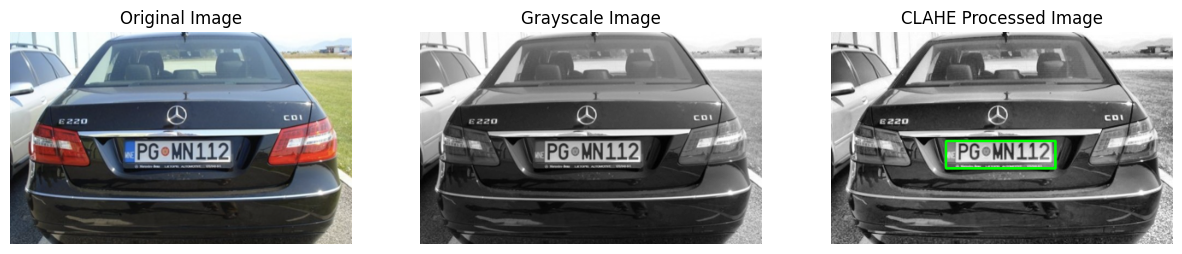

In [30]:
import cv2
import matplotlib.pyplot as plt
import os

image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for image and its label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Read the image using OpenCV
original_image = cv2.imread(image_path)

# Convert image to grayscale for CLAHE
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))


clahe_image = clahe.apply(gray_image)

# Convert CLAHE image back to BGR for visualization with bounding box
clahe_image_bgr = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)

# Read label file and draw bounding box on CLAHE image
with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = original_image.shape
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw bounding box on the CLAHE image
    cv2.rectangle(clahe_image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display original, grayscale, and CLAHE processed images side by side
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Grayscale image
plt.subplot(1, 3, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

# CLAHE processed image with bounding box
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(clahe_image_bgr, cv2.COLOR_BGR2RGB))
plt.title('CLAHE Processed Image')
plt.axis('off')

plt.show()


In [31]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

# Using YOLOv8 nano model

In [ ]:
# using YOLOv8 nano
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


In [ ]:
os.environ['WANDB_MODE'] = 'offline'

In [ ]:
#Train
model.train(
    data='datasets.yaml',
    epochs=100,
    batch=16,
    device='cuda',
    imgsz=320,  # Image size (width and height) for training
    cache=True
)

Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 107MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 607.05it/s]

train: New cache created: /content/datasets/cars_license_plate_new/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:05<00:00, 68.45it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 341.98it/s]

val: New cache created: /content/datasets/cars_license_plate_new/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 83.82it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.663G      1.804      2.961      1.364         19        320: 100%|██████████| 22/22 [00:07<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         44         44    0.00382      0.909      0.395      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.614G      1.505      1.629      1.126         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


                   all         44         44          1      0.328      0.439      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.625G      1.486      1.372      1.154         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44      0.746      0.201      0.336      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.617G      1.491       1.32      1.177         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         44         44      0.687      0.364       0.46      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.617G      1.483      1.243      1.168         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


                   all         44         44      0.584      0.192      0.259      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.617G       1.57      1.251      1.198         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.127      0.182     0.0611     0.0255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.617G      1.454      1.168      1.171         18        320: 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]

                   all         44         44     0.0127      0.227    0.00716    0.00246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.617G      1.469      1.134      1.138         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


                   all         44         44      0.636      0.545      0.509      0.253

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.617G       1.37      1.069      1.124         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         44         44      0.763      0.584      0.633      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.617G      1.375      1.009      1.125         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44       0.84      0.773      0.813      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.617G      1.356     0.9799      1.116         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


                   all         44         44      0.826      0.886      0.841      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.617G      1.398      0.983      1.117         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


                   all         44         44      0.725      0.841      0.827      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.614G      1.471     0.9803      1.145         15        320: 100%|██████████| 22/22 [00:03<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.74it/s]

                   all         44         44      0.852      0.886      0.884      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.617G      1.395     0.9481      1.123         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

                   all         44         44      0.925      0.847      0.908      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.617G      1.331      0.904      1.081         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.68it/s]

                   all         44         44      0.867      0.659      0.772      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.617G      1.338     0.9009      1.086         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44      0.865      0.795      0.852      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.617G        1.3     0.8657      1.094         16        320: 100%|██████████| 22/22 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]

                   all         44         44        0.8      0.773      0.824      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.617G      1.267     0.8275      1.078         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         44         44      0.791       0.86      0.869       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.614G      1.263     0.8106      1.094         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.867      0.909      0.899      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.617G      1.232     0.7883      1.063         24        320: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.59it/s]

                   all         44         44      0.892      0.886       0.89      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.617G      1.244     0.7824      1.056         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]


                   all         44         44       0.86      0.864      0.844      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.617G      1.262     0.8411      1.081         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]

                   all         44         44      0.869      0.907      0.873      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.617G      1.268     0.7951      1.063         14        320: 100%|██████████| 22/22 [00:03<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         44         44      0.928      0.882       0.93      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.617G      1.245     0.7656      1.088         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


                   all         44         44       0.84      0.795      0.838      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.617G      1.208     0.7781       1.06         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44       0.88       0.83      0.875      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.614G      1.211     0.7493      1.074         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]

                   all         44         44      0.835      0.864      0.874      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.617G       1.12     0.7196      1.044         18        320: 100%|██████████| 22/22 [00:02<00:00,  9.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.93it/s]

                   all         44         44      0.919      0.777      0.894      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.617G       1.11     0.6983      1.022         18        320: 100%|██████████| 22/22 [00:03<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         44         44      0.894      0.841      0.902      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.617G      1.112     0.7028       1.05         23        320: 100%|██████████| 22/22 [00:03<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


                   all         44         44      0.866      0.883      0.907      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.617G      1.111     0.6947       1.03         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.842      0.909      0.892      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.617G      1.136     0.7014      1.037         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         44         44      0.803      0.932      0.897      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.617G      1.093     0.6787      1.024         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]

                   all         44         44      0.958      0.841      0.922      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.617G      1.142     0.6759      1.038         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]

                   all         44         44      0.856      0.864      0.873      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.617G       1.05     0.6654      1.012         18        320: 100%|██████████| 22/22 [00:03<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.879      0.864      0.887      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.614G      1.068     0.6557      1.005         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]

                   all         44         44      0.886      0.909      0.927      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.617G      1.093       0.67      1.013         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

                   all         44         44      0.812      0.886      0.855      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.617G      1.101     0.6689       1.03         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]

                   all         44         44      0.844      0.886      0.895      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.617G      1.084      0.659      1.013         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         44         44      0.884      0.864      0.912      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.617G       1.03     0.6402      1.007         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


                   all         44         44      0.887      0.864      0.891      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.617G      1.053     0.6326     0.9963         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44      0.902      0.795      0.873      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.617G      1.044     0.6399      1.004         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         44         44      0.838       0.82      0.897      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.617G     0.9797     0.6097     0.9981         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


                   all         44         44      0.903      0.841      0.914      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.614G      1.013     0.6115     0.9899         14        320: 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


                   all         44         44      0.851      0.909      0.898      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.617G      1.036     0.6401     0.9753         13        320: 100%|██████████| 22/22 [00:02<00:00,  7.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]

                   all         44         44      0.885      0.877      0.905       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.614G      1.014     0.6077     0.9672         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         44         44      0.886      0.885      0.896      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.617G     0.9939     0.6203     0.9843         18        320: 100%|██████████| 22/22 [00:03<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.904      0.855      0.908       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.617G      1.007     0.6112     0.9794         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.60it/s]

                   all         44         44      0.829      0.879      0.892      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.617G      0.982     0.5732     0.9642         13        320: 100%|██████████| 22/22 [00:02<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.25it/s]

                   all         44         44      0.846      0.795      0.872      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.617G     0.9608     0.5661     0.9681         12        320: 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]

                   all         44         44      0.813      0.841      0.888      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.617G      1.023     0.6106      0.979         15        320: 100%|██████████| 22/22 [00:02<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.828      0.909      0.917        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.617G      0.972     0.5914      0.975         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

                   all         44         44      0.832      0.886      0.914      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.617G     0.9557     0.5778     0.9763         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         44         44      0.879      0.795      0.866      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.617G     0.9489     0.5618     0.9593         14        320: 100%|██████████| 22/22 [00:02<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.74it/s]

                   all         44         44      0.882      0.795      0.854      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.617G     0.9446     0.5725     0.9726         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


                   all         44         44       0.88      0.864      0.903      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.614G     0.9542     0.5996     0.9701         10        320: 100%|██████████| 22/22 [00:03<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

                   all         44         44      0.857      0.817      0.855       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.617G     0.9263     0.5684      0.954         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.826      0.863      0.884      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.617G     0.9142      0.562      0.959         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]

                   all         44         44      0.821      0.886      0.905      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.617G     0.9157     0.5605     0.9441         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]

                   all         44         44      0.903      0.818      0.904      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.614G     0.9176     0.5417     0.9511         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.34it/s]

                   all         44         44      0.847      0.909      0.914      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.617G     0.9209     0.5647     0.9643         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

                   all         44         44      0.864      0.886      0.897      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.617G     0.9221     0.5512     0.9689         19        320: 100%|██████████| 22/22 [00:03<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


                   all         44         44      0.866      0.884      0.913      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.617G     0.8937     0.5448     0.9576         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.99it/s]

                   all         44         44       0.85      0.818      0.879      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.614G     0.8649     0.5282      0.957          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         44         44      0.844      0.795      0.866      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.617G     0.8899     0.5376     0.9523         15        320: 100%|██████████| 22/22 [00:03<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]

                   all         44         44      0.825      0.864      0.869      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.617G     0.9199      0.543     0.9482         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.81it/s]

                   all         44         44      0.901      0.886       0.91      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.617G     0.8872     0.5191     0.9504         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]


                   all         44         44      0.847      0.883      0.894      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.614G     0.9154     0.5408     0.9462         11        320: 100%|██████████| 22/22 [00:03<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


                   all         44         44      0.875      0.864      0.887      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.617G      0.875     0.5141     0.9294         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.855      0.886      0.885      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.617G     0.8273     0.5239      0.942         17        320: 100%|██████████| 22/22 [00:03<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         44         44      0.939      0.795      0.875      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.617G     0.8404     0.5079     0.9361         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.63it/s]

                   all         44         44      0.847      0.909      0.916      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.614G     0.8645     0.5253     0.9319         17        320: 100%|██████████| 22/22 [00:02<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.78it/s]

                   all         44         44      0.823      0.864      0.891      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.617G     0.8396     0.5054      0.938         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


                   all         44         44      0.893      0.795      0.871      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.617G     0.8678     0.5139     0.9282         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.80it/s]

                   all         44         44      0.853      0.841      0.904      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.617G     0.8726     0.5145     0.9385         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.875      0.818      0.885      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.617G      0.847     0.5145     0.9541         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]

                   all         44         44       0.84      0.837      0.879      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.617G     0.8103     0.4859     0.9337         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]

                   all         44         44      0.811      0.877      0.875      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.617G     0.7883     0.4743     0.9199         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.83it/s]

                   all         44         44       0.82      0.864      0.891      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.617G     0.8246       0.49     0.9322         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]

                   all         44         44      0.897      0.795      0.897      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.617G     0.8185     0.4817     0.9323         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]

                   all         44         44       0.86      0.841      0.897      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.617G     0.8279     0.5063     0.9357         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


                   all         44         44      0.861      0.818      0.879      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.617G      0.801     0.4894     0.9268         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]

                   all         44         44      0.901      0.795      0.877      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.617G     0.7964      0.476     0.9173         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]

                   all         44         44      0.945      0.785      0.896      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.617G     0.7698     0.4698     0.9165         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         44         44       0.92      0.785      0.895      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.617G     0.7743     0.4697     0.9077         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         44         44      0.898      0.802      0.898      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.617G      0.796     0.4705     0.9231         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.98it/s]

                   all         44         44      0.902      0.773       0.89      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.617G     0.7766      0.474     0.9247         15        320: 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


                   all         44         44       0.92      0.787      0.895      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.614G     0.7478     0.4668     0.9029         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.40it/s]


                   all         44         44      0.917      0.773      0.888      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.617G     0.7466     0.4571     0.9218         14        320: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]

                   all         44         44      0.841      0.839      0.896      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.617G     0.7544     0.4545     0.9158         21        320: 100%|██████████| 22/22 [00:03<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.88it/s]

                   all         44         44      0.887      0.773      0.897      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.617G     0.7445     0.4433     0.9166         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.86it/s]

                   all         44         44      0.944       0.77      0.892      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.614G      1.011      0.543      1.021          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44       0.82      0.826      0.871      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.614G     0.9644     0.5174      1.013          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         44         44      0.825      0.841      0.863      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.614G      0.946     0.4973      1.012          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]

                   all         44         44      0.893      0.773      0.871      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.614G     0.9398     0.5082     0.9907          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44      0.913      0.773      0.866      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.614G     0.9583     0.4951     0.9971          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]


                   all         44         44      0.888      0.773      0.878      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.617G     0.9741     0.5052      1.002          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


                   all         44         44      0.886      0.773      0.878      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.614G     0.9271     0.4683     0.9859          9        320: 100%|██████████| 22/22 [00:02<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.36it/s]

                   all         44         44      0.891      0.795      0.882      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.614G     0.9085      0.493     0.9794          9        320: 100%|██████████| 22/22 [00:03<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]

                   all         44         44      0.921      0.795      0.884      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.614G     0.8936      0.473     0.9749          9        320: 100%|██████████| 22/22 [00:03<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.34it/s]

                   all         44         44      0.919      0.795      0.883       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.614G      0.891     0.4857     0.9759          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

                   all         44         44      0.915      0.795      0.884      0.542



100 epochs completed in 0.114 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.20 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


                   all         44         44      0.886      0.773      0.878      0.548
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
lr/pg1,▇███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
lr/pg2,▄▆███▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁
metrics/mAP50(B),▄▃▁▅▆█▇█▇████████████▇██████████████████
metrics/mAP50-95(B),▄▃▄▁▁▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇███▇▇█▇██████████
metrics/precision(B),▁█▅▁▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇
metrics/recall(B),▁▁▁▅▇▇███▇▇██▇███▇█▇█▇▇█▇▇▇██▇█▇▇▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,███▇▇▇▆▆▆▆▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6f81e95c30>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

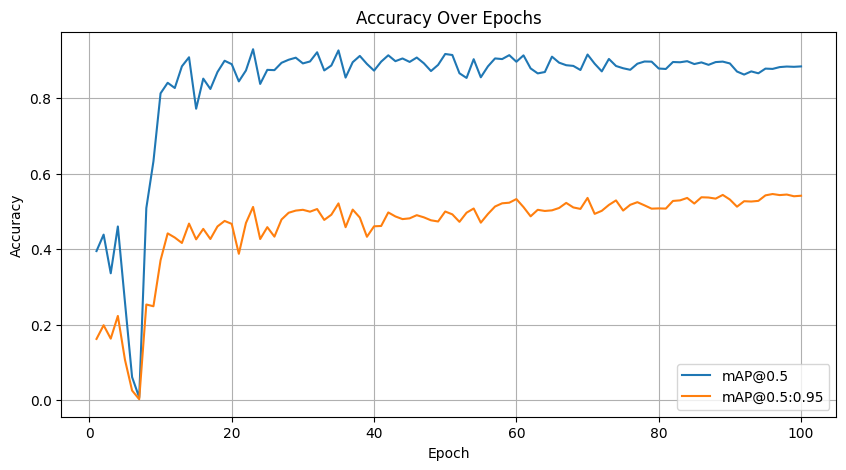

In [ ]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save model
model.save('license_plate_model_sauravdb.pt')

In [ ]:
import shutil

# Copy 'runs' file to Google drive
shutil.copytree('runs', '/content/drive/My Drive/runs', dirs_exist_ok=True)


'/content/drive/My Drive/runs'

# Test and predictions


image 1/1 /content/drive/MyDrive/archive/images/Cars364.png: 224x320 1 license_plate, 45.2ms
Speed: 0.9ms preprocess, 45.2ms inference, 1.1ms postprocess per image at shape (1, 3, 224, 320)


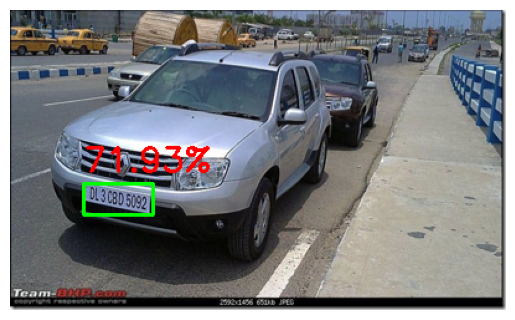


image 1/1 /content/drive/MyDrive/archive/images/Cars181.png: 320x192 1 license_plate, 63.3ms
Speed: 1.1ms preprocess, 63.3ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


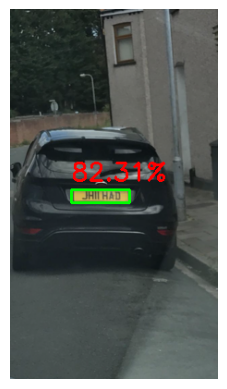


image 1/1 /content/drive/MyDrive/archive/images/Cars425.png: 160x320 1 license_plate, 46.2ms
Speed: 1.1ms preprocess, 46.2ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 320)


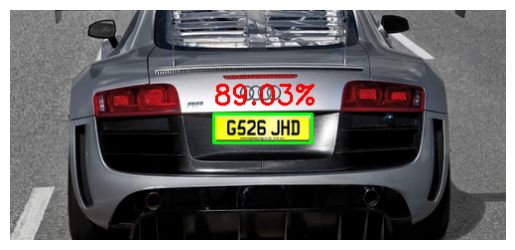

In [ ]:

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load best
model = YOLO('/content/drive/MyDrive/runs/detect/train/weights/best.pt')


def predict_and_plot(image_path):
    results = model.predict(image_path, device='cpu')

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


predict_and_plot(test.iloc[4].img_path)
predict_and_plot(test.iloc[2].img_path)
predict_and_plot(test.iloc[0].img_path)



image 1/1 /content/drive/MyDrive/archive/images/Cars364.png: 224x320 1 license_plate, 48.1ms
Speed: 0.9ms preprocess, 48.1ms inference, 0.9ms postprocess per image at shape (1, 3, 224, 320)


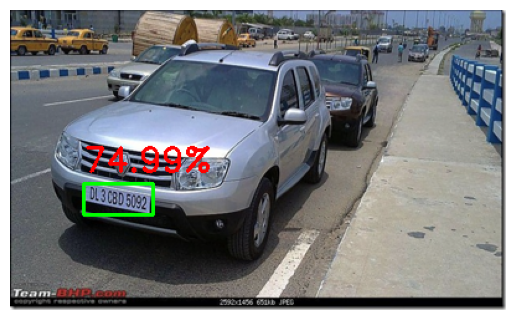


image 1/1 /content/drive/MyDrive/archive/images/Cars181.png: 320x192 1 license_plate, 71.2ms
Speed: 1.1ms preprocess, 71.2ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 192)


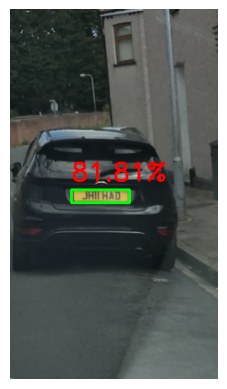


image 1/1 /content/drive/MyDrive/archive/images/Cars425.png: 160x320 1 license_plate, 44.0ms
Speed: 2.1ms preprocess, 44.0ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


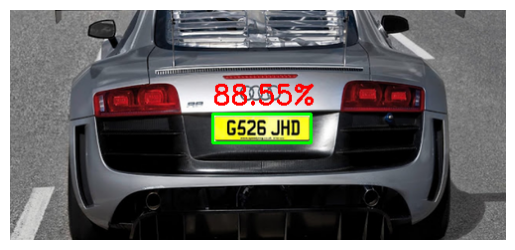

In [ ]:

import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load last
model = YOLO('/content/drive/MyDrive/runs/detect/train/weights/last.pt')


def predict_and_plot(image_path):
    results = model.predict(image_path, device='cpu')

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    plt.imshow(image)
    plt.axis('off')
    plt.show()


predict_and_plot(test.iloc[4].img_path)
predict_and_plot(test.iloc[2].img_path)
predict_and_plot(test.iloc[0].img_path)


In [ ]:
# to predict test image
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')


    image = cv2.imread(path_test_car)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)


    plt.imshow(image)
    plt.axis('off')
    plt.show()


image 1/1 /content/drive/MyDrive/archive/images/Cars425.png: 160x320 1 license_plate, 32.9ms
Speed: 0.6ms preprocess, 32.9ms inference, 14.0ms postprocess per image at shape (1, 3, 160, 320)


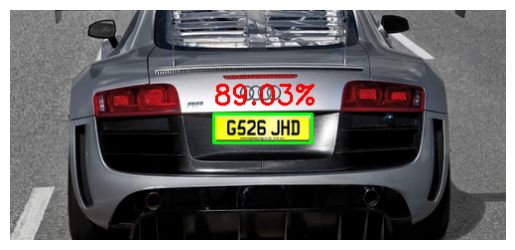

In [ ]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /content/drive/MyDrive/archive/images/Cars181.png: 320x192 1 license_plate, 63.7ms
Speed: 0.8ms preprocess, 63.7ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 192)


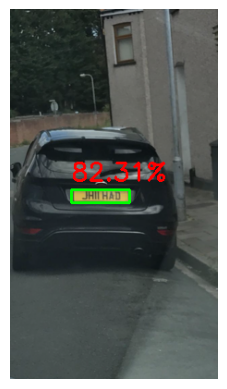

In [ ]:
predict_and_plot(test.iloc[2].img_path)


image 1/1 /content/drive/MyDrive/archive/images/Cars364.png: 224x320 1 license_plate, 75.9ms
Speed: 1.0ms preprocess, 75.9ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


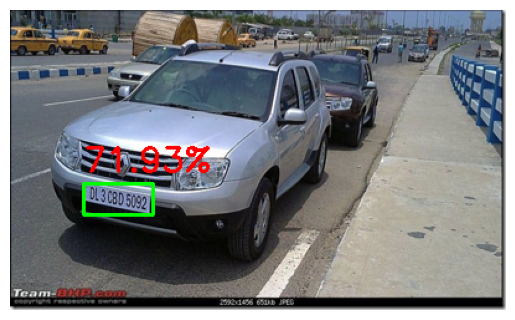

In [ ]:
predict_and_plot(test.iloc[4].img_path)

# Text Extraction OCR

In [ ]:
!pip3 install pytesseract

In [ ]:
import pytesseract
from pytesseract import Output

In [ ]:
def predict_and_plot(path_test_car):

    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


    for result in results:
        for box in result.boxes:

            x1, y1, x2, y2 = map(int, box.xyxy[0])

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # crop img
            roi = image[y1:y2, x1:x2]

        # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")


    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
predict_and_plot(test.iloc[0].img_path)

In [ ]:
predict_and_plot(test.iloc[10].img_path)

**We got number plate text as output above image**

:)